# Curso de Big Data

## Trabajo Práctico 3

### Samuel Arispe, Gonzalo Ochoa y Facundo Valle Quintana

### Reglas de formato y presentación
- El trabajo debe estar bien comentado (utilizando #) para que el código sea fácil de entender por sus compañeros y profesores.

- El mismo debe ser completado en este Jupyter Notebook y entregado como tal, es decir en un archivo .ipynb


### Fecha de entrega:
Domingo 5 de noviembre a las 23:59hs

### Contenidos:


Analizar el problema del no reporte de ingresos en las encuestas de hogares y cómo eso afecta la medición de la tasa de pobreza. Se profundizará en el análisis de esta temática con los nuevos métodos vistos en clase para identificar individuos sin reporte de ingresos.

### Modalidad de entrega
- Al finalizar el trabajo práctico deben hacer un último <i>commit</i> en su repositorio de GitHub con el mensaje “Entrega final del tp”.

- Asegurense de haber creado una carpeta llamada TP3. Deben entregar el código (jupyter notebook).

- También deben completar el link de su repositorio -para que pueda ser clonado y corregido- en la siguiente <a href="https://docs.google.com/spreadsheets/d/1v8Sv2TSzpK6mxjm3mmdnhmkk0qiyGFNj/edit#gid=1820558252">google sheet</a>

- La última versión en el repositorio es la que será evaluada. Por lo que es importante que:
    - No completen la google sheet hasta no haber terminado y estar seguros de que han hecho el <i>commit y push</i> a la versión final que quieren entregar. Debido a que se pueden tomar hasta 3 días de extensión a lo largo del curso, no se  corregirán sus tareas hasta no ver el link en la google sheet.\
    
    - No hagan nuevos <i>push</i> despues de haber entregado su versión final. Esto generaría confusión acerca de que versión es la que quieren que se les corrija.

### Reglas de formato y presentación

- El trabajo se debe entregar como Jupyter Notebook. Se espera una buena redacción en la resolución del práctico.

- Identifiquen claramente a qué inciso corresponde cada comando y, cuando sea necesario, usen bloques de texto para detallar sus respuestas.

- Importante: Todos los miembros del equipo deben haber hecho al menos un <i> commit </i> durante la realización del TP para asegurar que todos hayan aportado a su resolución.

## Parte I: Análisis de la base de hogares y cálculo de pobreza

Ahora que ya se han familiarizado con la Encuesta Permanente de Hogares (EPH) y
con la tabla de adulto equivalente, vamos a complejizar un poco la construcción del índice de pobreza. Lo calcularemos a nivel de hogares, con sus respectivos factores de expansión y realizaremos una limpieza de la base con mayor dedicación.
A continuación, complementamos el trabajo hecho en el TP2 usando la encuesta a
nivel hogares de la EPH.

#### 1. Exploren el diseño de registro de la base de hogar: a priori, ¿qué variables creen que pueden ser muy predictivas de pobreza y que sería muy útil incluir para perfeccionar el ejercicio del TP2?

Respuesta: A la hora de perfeccionar la predicción de la pobreza del TP2, consideramos que las siguientes variables pueden ser relevantes:

1. <b>Identificación</b>: retendríamos todas las variables, ya que nos permiten ubicar espacial y temporalmente a la pobreza.
<br>

2. <b>Características de la vivienda</b>: retendríamos las siguientes variables: IV1, IV2, V4, IV7, IV8, IV10, IV11, IV12_3, dado que identifican considiciones habitacionales subóptimas, que son claves determinantes de la pobreza siguiendo la lógica de Amartya Sen.
<br>

3. <b>Características habitacionales</b>: retendríamos las siguientes variables: II1, II3, II8, II9, V1, V2, V4, V5, V6, V12, V19_A, V19_B, IX_ToT, ITF, DECIFR, IPCF, DECCFR. Este conjunto de variables nos permite indagar sobre las dimensiones del hogar, el funcionamiento de sus baños y la fuente de los ingresos familiares lo que nos permite identificar a las personas más vulnerables.

#### 2. Descarguen la base de microdatos de la EPH correspondiente al primer trimestre de 2023 (la base de hogares se llama usu hogar T123.xls). Importen los datos de la encuesta de hogar y, al igual que en el TP2, conserven sólo las observaciones que corresponden a los aglomerados de Ciudad Autónoma de Buenos Aires o del Gran Buenos Aires.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(201)
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline
#from ISLP import load_data
from sklearn.preprocessing import scale
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statistics

In [2]:
# Cargamos la data
data_ind = pd.read_excel("usu_individual_T123.xlsx")
data_hog = pd.read_excel("usu_hogar_T123.xlsx")

In [3]:
#Filtrar datos para el área de Buenos Aires tanto a nivel individual como a nivel hogares
data_ind_baires = data_ind[data_ind['AGLOMERADO'].isin([32, 33])]
data_hog_baires = data_hog[data_hog['AGLOMERADO'].isin([32, 33])]

#### 3. Unan la tabla de la encuesta individual con la de la encuesta de hogar.

In [4]:
#Unimos los dos dataframes
#Se incluirán todas las filas de ambos DataFrames, conservando todas las filas aunque no haya coincidencias en las columnas de unión
data_unida = pd.merge(data_ind_baires, data_hog_baires, on=['CODUSU','NRO_HOGAR'], how='outer')

# Seleccionar las columnas que tienen el sufijo a borrar
variables_duplicadas = data_unida.filter(like='_y', axis=1)

# Borrar las columnas seleccionadas del DataFrame
data_unida = data_unida.drop(variables_duplicadas.columns, axis=1)

#### 4. Generen sus propias funciones para limpiar la base de datos o, si deciden utilizar funciones existentes en paquetes como numpy y pandas, mencionen cúales usarán y de qué paquetes son.

In [5]:
# Borramos todas las variables que tienen mas del 50% de missings
proporcion_missing_values = data_unida.isnull().mean()

# Filtra las columnas que tienen más del 50% de missing values
#   todas las variables relacionadas los desocupados tienen mas del 70% de NaN
#   todas las variables relacionadas a los ocupados tienen mas del 50% de NaN
#   Tambien eliminamos las variables relacionadas a la categoría otros y CH14 que se refiere al último año que aprobó, que es redundante dado que ya tenemos nivel educativo (NIVEL_ED).
columnas_50_missing = proporcion_missing_values[proporcion_missing_values > 0.5].index
print(columnas_50_missing)
# Eliminar las columnas seleccionadas del DataFrame
data_unida_drop50 = data_unida.drop(columnas_50_missing, axis=1)

data_unida_drop50['CH08'].fillna(9, inplace=True)
# Sólo reemplazamos esta variable con NS/NR  ya que solo tiene un missing value.
# P47T tiene 24 missing values pero es una variable de ingreso y luego será eliminada

data_unida_drop50['CH08'] = data_unida_drop50['CH08'].astype('int64')

Index(['CH14', 'CH15_COD', 'CH16_COD', 'IMPUTA', 'PP03C', 'PP03D', 'PP3E_TOT',
       'PP3F_TOT', 'PP03G', 'PP03H',
       ...
       'PDECINDR', 'IDECIFR_x', 'PDECIFR_x', 'IDECCFR_x', 'PDECCFR_x',
       'IV1_ESP', 'IV3_ESP', 'IV7_ESP', 'II7_ESP', 'II8_ESP'],
      dtype='object', length=107)


#### 5. Limpien la base de datos tomando criterios que hagan sentido, tanto para el tratamiento de valores faltantes, de outliers, como así también decidan qué variables categóricas y strings usarán y transfórmenlas de forma que haga sentido para los ejercicios siguientes. Justifiquen sus decisiones.

In [6]:
variables_a_verificar = ['IV2','II1','IX_TOT','IX_MEN10','IX_MAYEQ10','ITF_x','CH06','CH12','NIVEL_ED']
# Vemos que CH6=Edad tiene valores negativos, por lo tanto se elimina esas observaciones
# Así como las observaciones que tienen 99 en variables numericas discretas que claramente son missing; menos la edad puede ser 99
data_unida_drop50[variables_a_verificar].describe().T

,count,mean,std,min,25%,50%,75%,max
IV2,7619.0,3.075338,1.933210,1.0,2.0,3.0,4.0,99.0
II1,7619.0,3.056307,1.928454,0.0,2.0,3.0,4.0,99.0
IX_TOT,7619.0,3.696417,1.852985,1.0,2.0,4.0,5.0,13.0
IX_MEN10,7619.0,0.601391,0.947037,0.0,0.0,0.0,1.0,8.0
IX_MAYEQ10,7619.0,3.095026,1.441937,1.0,2.0,3.0,4.0,10.0
ITF_x,7619.0,138407.892637,334941.671900,0.0,0.0,75000.0,200000.0,10990000.0
CH06,7619.0,37.177845,22.738454,-1.0,18.0,35.0,55.0,99.0
CH12,7619.0,4.093451,2.942823,0.0,2.0,4.0,6.0,99.0
NIVEL_ED,7619.0,3.799842,1.746307,1.0,3.0,4.0,5.0,7.0


<Axes: xlabel='variable', ylabel='value'>

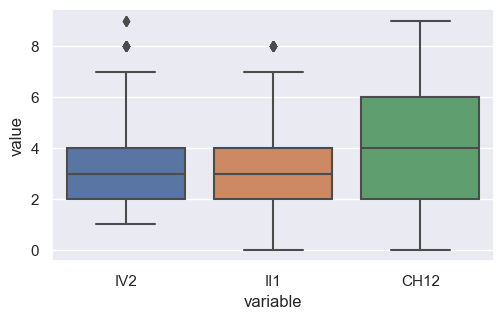

In [7]:
# Chequeamos variables numericas discretas con 99
variables_a_verificar = ['IV2','II1','CH12']  # Lista de variables a verificar
# Utiliza el método drop para eliminar las filas que cumplan con la condición
data_unida_drop50 = data_unida_drop50.drop(data_unida_drop50[(data_unida_drop50[variables_a_verificar] == 99).any(axis=1)].index)

sns.set(rc={'figure.figsize':(5.7,3.27)})
sns.boxplot(x="variable", y="value", data=pd.melt(data_unida_drop50[variables_a_verificar]))

In [8]:
# Obervaciones con valores negativos en variables que no corresponde
variables_negativas = ['CH06']
data_unida_drop50 = data_unida_drop50.drop(data_unida_drop50[(data_unida_drop50[variables_negativas] < 0).any(axis=1)].index)

# Le damos formato de variables categóricas a las variables resepctivas con Sí, No, o categorías diferentes.

variables_categoricas = ['IV1','IV2','IV3','IV4','IV5','IV6','IV7','IV8','IV9','IV10',
                         'IV11','IV12_1','IV12_2','IV12_3','II3','II4_1','II4_2',
                         'II4_3','II5','II6','II7','II8','II9','V1','V2','V21',
                         'V22','V3','V4','V5','V6','V7','V8','V9','V10','V11',
                         'V12','V13','V14','V15','V16','V17','V18','V19_A','V19_B',
                         'CH03','CH04','CH07','CH08','CH09','CH10','CH11','CH13','CH15',
                         'CH16','ESTADO','CAT_OCUP','CAT_INAC','PP02C1','PP02C2',
                         'PP02C3','PP02C4','PP02C5','PP02C6','PP02C7','PP02C8',
                         'PP02E','PP02H','PP02I']

# Volvemos categóricas todas estas varaibles seleccionadas
data_unida_drop50[variables_categoricas] = data_unida_drop50[variables_categoricas].astype('category')
#data_unida_drop50[variables_categoricas].info()

for columna in variables_categoricas:
    dummies = pd.get_dummies(data_unida_drop50[variables_categoricas][columna], prefix=columna)
    data_unida_drop50 = pd.concat([data_unida_drop50, dummies], axis=1)

<Axes: xlabel='variable', ylabel='value'>

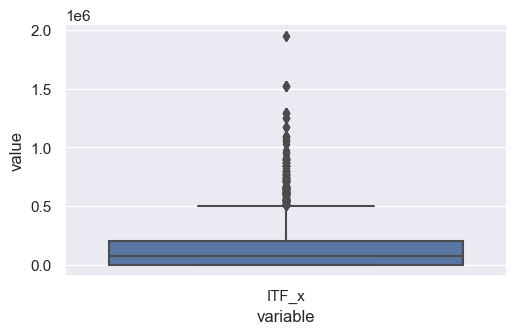

In [9]:
# De las variables de ingreso solo vemos la variable de ingreso total porque después se eliminarán todas las variables relacionadas a ingresos
# La variable de ingreso del hogar tiene outlier (10990000), que puede distorsionar todo. Solo eliminamos esas observaciones
ingreso = ['ITF_x']  # Lista de variables a verificar
data_unida_drop50 = data_unida_drop50.drop(data_unida_drop50[(data_unida_drop50[ingreso] >= 10990000).any(axis=1)].index)

sns.set(rc={'figure.figsize':(5.7,3.27)})
sns.boxplot(x="variable", y="value", data=pd.melt(data_unida_drop50[ingreso]))

#### 6. Presenten estadísticas descriptivas de cinco variables de la encuesta de hogar que ustedes creen que pueden ser relevantes para predecir pobreza.

In [10]:
#calculamos las estadísticas descriptivas para estas variables:

#CH06: Años cumplidos
#IX_TOT: Cantidad de miembros en el hogar
#CH12: Nivel de estudios más alto que cursa o que cursó
#IPCF_x: Monto del ingreso per cápita familiar
#NIVEL_ED: Nivel educativo

variables = ['CH06', 'IX_TOT', 'CH12', 'IPCF_x', 'NIVEL_ED']

resultados = []
for var in variables:
    promedio = data_unida_drop50[var].mean()
    mediana = data_unida_drop50[var].median()
    desviacion_estandar = data_unida_drop50[var].std()
    minimo = data_unida_drop50[var].min()
    maximo = data_unida_drop50[var].max()
    resultados.append([var, promedio, mediana, desviacion_estandar, minimo, maximo])

data_unida_drop50[variables].describe().T

,count,mean,std,min,25%,50%,75%,max
CH06,7560.0,37.409921,22.604266,1.0,18.0,36.00,55.0,99.0
IX_TOT,7560.0,3.690079,1.853650,1.0,2.0,4.00,5.0,13.0
CH12,7560.0,4.067063,1.961361,0.0,2.0,4.00,6.0,9.0
IPCF_x,7560.0,46105.922823,73415.171857,0.0,0.0,20142.86,65000.0,980000.0
NIVEL_ED,7560.0,3.778836,1.733548,1.0,3.0,4.00,5.0,7.0


<b>CH06</b>: Vemos que la edad promedio de nuestra muestra es de 37 años, con un considerable desvío estándar de 22 (esperable); el último cuartil arranca en los 55 años, con un dato máximo de 99 años.
<br>

<b>IX_TOT</b>: La cantidad de miembros en el hogar promedio de nuestra muestra es de 3, inclinándose ligeramente hacia 4; con un desvío estándar de 1.85, estos resultados son los esperados para un país como argentino. Cabe mencionar el máximo de 13 encontrado, muy alejado del resto.
<br>

<b>CH12</b>: Vemos que el nivel educativo en curso/cursado es en promedio el secundario (4.06). Con un desvío estándar de casi 2, podemos interpretar que la gran mayoría de la población completó el primario y terciario, los universitarios y posgrados universitarios siendo outliers.
<br>

<b>IPCF_x</b>: Para el Ingreso Per Cápita Familiar (IPCF) apreciamos que el promedio es de $46,000, con un desvío que supera los $73,000 sugiriendo una importante dispersión de los datos, y entonces desigualdad en los ingresos, hipótesis reforzada por los resultados de los cuartiles: del 2do cuartil al tercero hay una diferencia de casi $40,000 y encontramos un valor máximo de $980,000.
<br>

<b>NIVEL_ED</b>: En el nivel educativo, encontrao,s que el promedio de la población no alcanza el secundario completo (4). Además, vemos que la gran cantidad de nuestra muestra (hasta el 3er cuartil) solamente alcanza el superior universitario incompleto (5), sugiriendo que el universitario completo y los posgrados y doctorados son verdaderos outliers en Argentina.
<br>


#### 7. Repitan el inciso 1.2.f del TP2 para construir la columna <i>adulto_equiv</i> y la columna <i>ad_equiv_hogar</i> (pueden utilizar su código del TP2).

Volvemos a emplear nuestro código del TP2.

In [11]:
#cargamos los datos y renombramos las columnas
data_adult=pd.read_excel("tabla_adulto_equiv.xlsx", header = 4, nrows=23, ) #formateamos para que se cargue correctamente la base.
data_adult.rename({'Unnamed: 0':'Edad','Unnamed: 1':'Mujeres','Unnamed: 2':'Hombres'}, axis=1, inplace = True) # Renombramos las columnas.

In [12]:
def calcular_adulto_equiv(sexo, edad): # Esta función toma dos argumentos: el sexo y la edad. Mediante un "if" filtra primero por sexo y luego por edad, para devolvernos el valor de adulto equivalente correspondiente.
    # para los hombres:
    if sexo == 1:
        if edad < 1:
            return 0.35
        elif edad == 1:
            return 0.37
        elif edad == 2:
            return 0.46
        elif edad == 3:
            return 0.51
        elif edad == 4:
            return 0.55
        elif edad == 5:
            return 0.6
        elif edad == 6:
            return 0.64
        elif edad == 7:
            return 0.66
        elif edad == 8:
            return 0.68
        elif edad == 9:
            return 0.69
        elif edad == 10:
            return 0.79
        elif edad == 11:
            return 0.82
        elif edad == 12:
            return 0.85
        elif edad == 13:
            return 0.90
        elif edad == 14:
            return 0.96
        elif edad == 15:
            return 1
        elif edad == 16:
            return 1.03
        elif edad == 17:
            return 1.04
        elif 18 <= edad <= 29:
            return 1.02
        elif 30 <= edad <= 45:
            return 1.00
        elif 46 <= edad <= 60:
            return 1.00
        elif 61 <= edad <= 75:
            return 0.83
        elif edad > 75:
            return 0.74
        else:
            print("hay un problema")

    # Para las mujeres:
    elif sexo == 2:
        if edad < 1:
            return 0.35
        elif edad == 1:
            return 0.37
        elif edad == 2:
            return 0.46
        elif edad == 3:
            return 0.51
        elif edad == 4:
            return 0.55
        elif edad == 5:
            return 0.6
        elif edad == 6:
            return 0.64
        elif edad == 7:
            return 0.66
        elif edad == 8:
            return 0.68
        elif edad == 9:
            return 0.69
        elif edad == 10:
            return 0.70
        elif edad == 11:
            return 0.72
        elif edad == 12:
            return 0.74
        elif edad == 13:
            return 0.76
        elif edad == 14:
            return 0.76
        elif edad == 15:
            return 0.77
        elif edad == 16:
            return 0.77
        elif edad == 17:
            return 0.77
        elif 18 <= edad <= 29:
            return 0.76
        elif 30 <= edad <= 45:
            return 0.77
        elif 46 <= edad <= 60:
            return 0.76
        elif 61 <= edad <= 75:
            return 0.67
        elif edad > 75:
            return 0.63
        else:
            print("hay un problema")

# Ahora aplicamos la función a nuestro dataframe, y guardamos el valor que nos arroja la función en una nueva columna.
data_unida_drop50['adulto_equiv'] = data_unida_drop50.apply(lambda row: calcular_adulto_equiv(row['CH04'], row['CH06']), axis=1).copy()

In [13]:
# Agrupamos los datos por "CODUSU" y "NRO_HOGAR," 
# Calculamos la suma del valor del adulto equivalente en cada grupo de hogares
# Agrega ese valor como una nueva columna
data_unida_drop50["ad_equiv_hogar"] = data_unida_drop50.groupby(['CODUSU', 'NRO_HOGAR'])["adulto_equiv"].transform('sum')

#### 8. Repitan el inciso 1.3 y 1.4 del TP2 para dividir la base en dos dataframes donde: uno conserve las personas que no reportaron ITF (dataframe llamado <i> respondieron </i>) y otro conserve a las personas que no reportaron ITF (llamado <i> norespondieron </i>). Además, agreguen a la base respondieron una columna llamada <i>ingreso_necesario</i> que sea el producto de la canasta básica por <i>ad_equiv_hogar</i>.

In [14]:
# Guardamos un dataframe con los datos de las personas que si contestaron.

respondieron = data_unida_drop50[data_unida_drop50["ITF_x"]!=0]

# Guardamos en otro data frame las personas que no respondieron.

norespondieron = data_unida_drop50[data_unida_drop50["ITF_x"]==0]

#### 9. Agreguen a la base respondieron una columna llamada pobre, que tome valor1 si el ITF es menor al ingreso necesario que necesita esa familia y 0 en caso contrario.

In [15]:
#Calculamos un valor basado en el valor del adulto equivalente en el hogar.
def CBT (ad_equiv_hogar):
    return ad_equiv_hogar * 57371.05

#Creamos una Nueva Columna llamada "ingreso_necesario":
respondieron['ingreso_necesario'] = respondieron.apply(lambda row: CBT(row['ad_equiv_hogar']), axis=1).copy()

#Esta función nos indica las personas pobres, cuyo ingreso es menor al necesario.
def polenta(hornero, hornero_necesario):
    if hornero < hornero_necesario:
        return 1
    else:
        return 0

respondieron['pobre'] = respondieron.apply(lambda row: polenta(row['ITF_x'], row['ingreso_necesario']), axis=1)

respondieron['pobre'].value_counts()

C:\Users\cufa9\AppData\Local\Temp\ipykernel_5116\1089956271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['ingreso_necesario'] = respondieron.apply(lambda row: CBT(row['ad_equiv_hogar']), axis=1).copy()
C:\Users\cufa9\AppData\Local\Temp\ipykernel_5116\1089956271.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['pobre'] = respondieron.apply(lambda row: polenta(row['ITF_x'], row['ingreso_necesario']), axis=1)


0    2618
1    1555
Name: pobre, dtype: int64

<b>1555</b> personas que respondieron son consideradas pobres, mientras que 2618 no lo son. 
<br>
Esto significa un <b>37.26%</b> de pobreza para nuestra muestra.

#### 10. En el TP2 calcularon los individuos bajo la línea de pobreza. Sin embargo, cuando se habla de pobreza el número más utilizado es el de la tasa de hogares bajo la línea de pobreza. Para calcularlo, utilicen una sola observación por hogar y sumen el ponderador PONDIH que permite expandir la muestra de la EPH al total de la población que representa. ¿Cuál es la tasa de hogares bajo la línea de pobreza para el GBA? ¿Se asemeja al que reporta el  <a href="https://www.indec.gob.ar/uploads/informesdeprensa/eph_pobreza_09_2326FC0901C2.pdf">INDEC en sus informes</a>?



In [16]:
#Creamos base con solo una observacion por hogar
respondieron_hogares=respondieron.groupby(['CODUSU','NRO_HOGAR']).agg({"pobre" : "mean","PONDERA_x" : "sum"})
#Sumamos cuanto hay de cada uno.
sumas=respondieron_hogares.groupby("pobre").PONDERA_x.sum().to_frame()
respondieron_porcentajes = sumas.apply(lambda x:
                                                 100 * x / float(x.sum()))
print(respondieron_porcentajes)

       PONDERA_x
pobre           
0.0    58.705162
1.0    41.294838


Los resultados muestran que, a nivel de hogares, el <b>58.71%</b> de los hogares no se consideran "pobres", mientras que el <b>41.29%</b> de los hogares se consideran "pobres".
<br>

El INDEC en su informe, señala que el porcentaje de hogares bajo la linea de pobreza para el GBA es del <b>30.3%</b>, mucho menor a lo que nosotros calculamos.